# Homework 3 (100 points)

The goal of this homework is to practice techniques relating to SVD.

## Exercise 1 (65 points)

a) Fetch the "mnist_784" data and store is as a `.csv` (that way you don't have to fetch it every time - which takes about 30s). (4 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.datasets import fetch_openml

X, y = fetch_openml(name="mnist_784", version=1, return_X_y=True, as_frame=True)

save_X = X.to_csv('name.csv', index = False)
save_y = y.to_csv('target.csv', index = False)

In [2]:
X = pd.read_csv('name.csv').to_numpy()
y = pd.read_csv('target.csv').to_numpy()

b) Plot the singular value plot for a single example of the 0 digit (5 points)

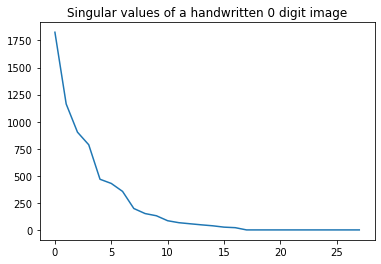

In [3]:
# Row 1 is a 0 digit (y[1][0] = 0)

zero_digit_im = X[1].reshape(28,28)

u,s,v=np.linalg.svd(zero_digit_im,full_matrices=False)

plt.plot(s)
plt.title('Singular values of a handwritten 0 digit image')
plt.show()

c) By setting some singular values to 0, plot the approximation of the 0 digit next to the original digit. (5 points)

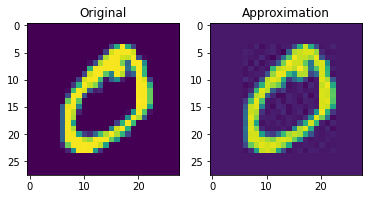

In [4]:
original_0 = zero_digit_im #28x28

s_copy = s.copy()

s_copy[10:] = 0

# recompile into approximated image
rank_10_0 = u.dot(np.diag(s_copy)).dot(v)

plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(zero_digit_im)

plt.subplot(1,2,2)
plt.title('Approximation')
plt.imshow(rank_10_0)

In [5]:
rank_10_0.shape

(28, 28)

d) Consider the entire dataset as a matrix. Perform SVD and store the dataset approximation in a new `.csv` file. Explain why / how you chose a particular rank. (10 points)

In [6]:
X_28 = X.reshape(70000,28,28)
X_svd = X_28.copy()
RANK_D = 15

for i in range(len(X_28)):
    u2, s2, v2 = np.linalg.svd(X_28[i], full_matrices=True)
    s2_copy = s2.copy()
    s2_copy[RANK_D:] = 0
    rank_recomp = u2.dot(np.diag(s2_copy)).dot(v2)
    X_svd[i] = rank_recomp

X_svd = X_svd.reshape(70000,784)

save_X_svd = pd.DataFrame(X_svd).to_csv('name_SVD.csv', index = False)

In [7]:
X_svd_data = pd.read_csv('name_SVD.csv').to_numpy()

I chose rank 15 as it is a much lower rank than the original, yet retains a low level of image distortion.  I came to the conclusion of rank 15 after testing many other ranks, below 15 incurred too much distortion.  This image distortion became apparant when testing Kmeans.

e) As in homework 2, using Kmeans on this new dataset, cluster the images from d) using 10 clusters and plot the centroid of each cluster. (10 points)

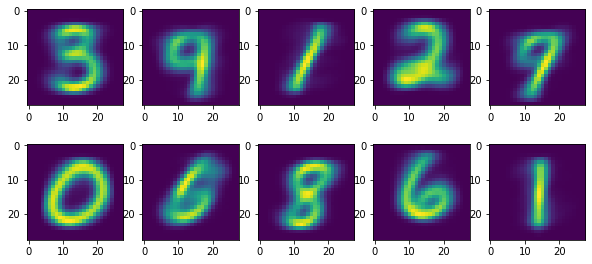

In [8]:
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits

kmeans_e = KMeans(n_clusters=10)
kmeans_e.fit(X_svd_data.data)

# convert 10,64 to 10,8,8 for plotting
centroids_28_28 = np.reshape(kmeans_e.cluster_centers_, [10,28,28])

# plot
plt.figure(figsize = (10,9))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.subplots_adjust(bottom=.5)
    plt.imshow(centroids_28_28[i])


f) Repeat e) on the original dataset. Comment on any differences (or lack thereof) you observe. (8 points)

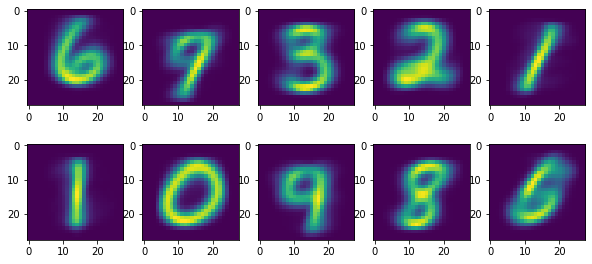

In [9]:
from sklearn.cluster import KMeans

kmeans_f = KMeans(n_clusters=10)
kmeans_f.fit(X.data)

# convert 10,64 to 10,8,8 for plotting
centroids_28_28_f = np.reshape(kmeans_f.cluster_centers_, [10,28,28])

# plot
plt.figure(figsize = (10,9))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.subplots_adjust(bottom=.5)
    plt.imshow(centroids_28_28_f[i])

Surprisingly each kmeans centroids plot were each missing a value (5 and 4 respectively).  Barring that difference the rest of the centroids appear similar.  The svd dataset also appears to have comparable resolution.

g) Compare the disagreement distance of the clustering obtained in e) to the true labels, to the disagreement distance of the clustering obtained in f) to the true labels. Comment briefly. (8 points)

In [10]:
from itertools import combinations

def disagreement_dist(P_labels, C_labels):
    p_c = np.vstack([P_labels, C_labels]).transpose()

    disagreement_d = 0

    for i in combinations(p_c, 2):
        if (i[0][0] == i[1][0]) or (i[0][1] == i[1][1]):
            disagreement_d += 1 

    return(disagreement_d)

y = y.reshape(70000,) # was (70000,1)

dd = disagreement_dist(y, kmeans_e.labels_)

print(f'The disagreement distance is equal to: {dd}.')

The disagreement distance is equal to: 399038015.


The disagreement distance at face value appears to be large, but considering the amount of possible combinations this number is relatively low.  The clustering is similar, yet meaningfully different.

h) Create a matrix that is the difference between the original dataset and the rank-10 approximation of the dataset. (10 points)

In [11]:
X_28_h = X.reshape(70000,28,28)
X_svd_h = X_28_h.copy()
RANK_h = 10

for i in range(len(X_28_h)):
    u3, s3, v3 = np.linalg.svd(X_28_h[i], full_matrices=True)
    s3_copy = s3.copy()
    s3_copy[RANK_h:] = 0
    rank_recomp3 = u3.dot(np.diag(s3_copy)).dot(v3)
    X_svd_h[i] = rank_recomp3

X_svd_h = X_svd_h.reshape(70000,784)


diff_matrix = X - X_svd_h

i) The largest (using euclidean distance from the origin) rows of the matrix could be considered anomalous data points. Briefly explain why. Plot the 10 images responsible for the 10 largest rows. (5 points)

In [12]:
# With the assumption that the origin is 0, the row sums of the difference matrix should give us the cumulative euclidean distance for each row

diff_matrix_sum = diff_matrix.copy()

sum_diff = abs(diff_matrix.sum(axis=1))

sum_diff_df = pd.DataFrame(sum_diff)

sum_diff_df.sort_values(by=0, ascending=False).head(10)

,0
40514,316.226496
22704,287.952734
62432,179.357995
46003,149.617677
41074,144.326414
9248,137.129268
10394,131.421744
45757,128.135128
41717,125.845117
52272,123.246169


Above we can see the index of the top 10 anomalous data rows.

In [13]:
anomalous_indices = [40514,22704,62432,46109,46003,10394,9248,41074,41717,45757]

anomalous_rows = X_svd_h[anomalous_indices]

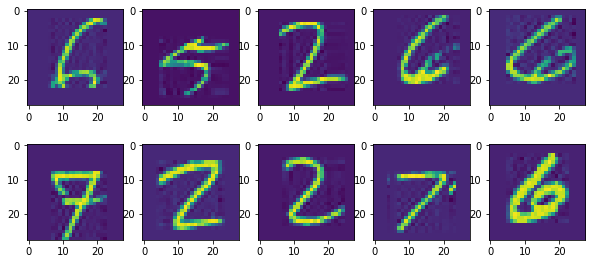

In [14]:
anomalous_rows_28_28 = np.reshape(anomalous_rows, [10,28,28])

#plot anomalous row images
plt.figure(figsize = (10,9))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.subplots_adjust(bottom=.5)
    plt.imshow(anomalous_rows_28_28[i])

I can ascribe these to be anomalous data points using the difference matrix, as I have found the 10 images that shifted the most after applying svd (compared to the original matrix).   The images do appear to be anomalous.

## Exercise 2 (35 points)

a) Modify the code below to pick 4 categories of news articles that you think are minimally related (for example `sci.space` and `rec.sport.baseball`). (3 points)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

categories = ['sci.space', 'rec.sport.hockey', 'comp.graphics', 'alt.atheism']
news_data = fetch_20newsgroups(subset='train', categories=categories)

b) Using the `SnowballStemmer`, stem the words in every article (10 points)

In [17]:
stemmed = [' '.join(SnowballStemmer('english', ignore_stopwords=True).stem(word)  #stopwords not stemmed
        for sent in sent_tokenize(message)
        for word in word_tokenize(sent))
        for message in news_data.data]

c) Use the `TfidfVectorizer` on the stemmed articles. Set `min_df` and `max_df` to reasonable numbers and briefly explain your reasoning. Store the resulting dataset into a `.csv` file. (7 points)

In [22]:
vectorize = TfidfVectorizer(stop_words='english', lowercase=True, min_df=5,max_df=0.75)

stemmed_vectorized = vectorize.fit_transform(stemmed)
feature_names = vectorize.get_feature_names()

I set the min_df to 3 to filter out terms that would likely not be relevant to clustering distinction.  I set max_df to 75% frequency for a similar reason, if the vocab term appears greater than 75% it is likely irrelevant to cluster distinction. 

In [23]:
save_stemmed_vectorized = pd.DataFrame(stemmed_vectorized).to_csv('stemmed_vectorized.csv', index = False)


d) For rank k ranging from 1 to 25:

1. Reduce the dimensionality of the tfidf vectorized data using a dimension reduction technique discussed in class.
2. Apply Kmeans on the reduced dataset to create 4 clusters
3. Record the disagreement distance between the clustering in 2 and the article category

Then plot the recorded disagreement distance per rank. Comment briefly. (15 points)

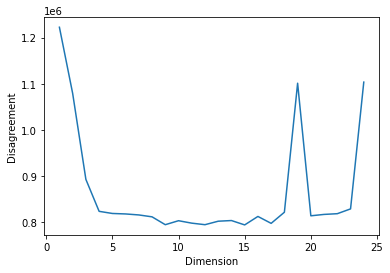

In [38]:
# mean center data
stemmed_vectorized_centered = stemmed_vectorized - np.mean(stemmed_vectorized, axis = 0)


disagreement_distance = []
for k in range(1,25):
    #apply svd/reduce dataset
    u_d, s_d, v_d = np.linalg.svd(stemmed_vectorized_centered, full_matrices=True)
    s_d[k:] = 0
    z = np.zeros((4486,2257))
    s_full = (np.concatenate((np.diag(s_d), z))).T
    stemmed_vectorized_centered_svd = np.matmul(u_d, np.matmul(s_full,v_d))
    dim_reduced_dataset = stemmed_vectorized_centered_svd
    #apply kmeans
    kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(dim_reduced_dataset)
    #compute disagreement distance
    labelsk = kmeans.labels_
    disagreement_distance.append(disagreement_dist(labelsk, news_data.target))

plt.plot(range(1,25), disagreement_distance)
plt.ylabel('Disagreement')
plt.xlabel('Dimension')
plt.show()

It appears that as rank (k) increases the disagreement distance to the true labels, goes down.  This is what we would expect, as we retain more data as rank increases.  This is still impressive as there is a massive reduction in rank. It is unclear to me why there a specific spikes in disagreement distance, however I believe that these would smooth out if running k all the way to full rank.